# Image Seaching 부터 Multi Modality 로 의 확장

  - Image 의 Feature Vector 를 이용한 서칭
  - CLIP 모델을 이용한 Text / Image 연관성 확보
    - Zero - Shot Prediction 구현 하기!
    - Text to Image 서칭 구현하기!




In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import tf_keras as keras

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [ ]:
model_name = "mobilenet_v2_100_224"
model_handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
pixels = 224

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Input size (224, 224)


In [ ]:
print("Building model with", model_handle)
model = keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle),
])

model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  (None, 1280)              2257984   
 per)                                                            
                                                                 
Total params: 2257984 (8.61 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## 데이터 준비

- Image Captioned 데이터 읽기

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
import urllib
import zipfile

In [ ]:
def download_and_extract_data():
    url = 'https://fastcampusjhpark.s3.ap-northeast-2.amazonaws.com/2023samsungAIchallenge_sampled.zip'
    urllib.request.urlretrieve(url, '2023samsungAIchallenge.zip')
    with zipfile.ZipFile('2023samsungAIchallenge.zip', 'r') as zip_ref:
        zip_ref.extractall()

download_and_extract_data()

wd = "./2023samsungAIchallenge_sampled/"

csv_file_path = wd + "sampled_train.csv"
df = pd.read_csv(csv_file_path)

In [ ]:
def preprocess_image(image_path, target_size):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(target_size)
        image = np.array(image) / 255.0  # Normalize the image to [0, 1] range
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

image_paths = df['img_path'].tolist()  # Replace with your column name
images = [preprocess_image(wd + image_path, IMAGE_SIZE) for image_path in image_paths]
images = np.array(images)

In [ ]:
feature_vectors = model.predict(images, batch_size=BATCH_SIZE)

63/63 [==============================] - 10s 29ms/step


In [ ]:
df['feature_vector'] = pd.Series(feature_vectors.tolist(), index=df.index[:len(feature_vectors)])
df

img_name                img_path       mos  \
0    8wej0zjjcg  ./train/8wej0zjjcg.jpg  5.393064   
1    7tp8y2wa0o  ./train/7tp8y2wa0o.jpg  5.668919   
2    njj6uo8dl7  ./train/njj6uo8dl7.jpg  4.550725   
3    gi7egofua1  ./train/gi7egofua1.jpg  5.661765   
4    jfobhikir5  ./train/jfobhikir5.jpg  2.400901   
..          ...                     ...       ...   
995  q9l9o2ym98  ./train/q9l9o2ym98.jpg  5.679144   
996  inuzo3y4sg  ./train/inuzo3y4sg.jpg  6.139535   
997  d9chiie2q3  ./train/d9chiie2q3.jpg  5.955479   
998  hr04byldlo  ./train/hr04byldlo.jpg  6.158537   
999  oqe121r97w  ./train/oqe121r97w.jpg  6.387435   

                                              comments  \
0    lovely photo, maybe a bit too dark because of ...   
1    i really like the way you have done these laye...   
2    cute and classy! i like this a lot especially ...   
3    nice and spooky, and you fit the bill for one ...   
4    im really trying to get this, but i dont. blue...   
..                                                 ...   
995  one of my s for the week. the colors are almos...   
996  lovely effect on the flowers with the backligh...   
997  very good! i love the grainyedgy look to it, b...   
998  very cute, and the colours are so warm, i can ...   
999  truly eerie. the use of light and shadows is d...   

                                        feature_vector  
0    [0.018101582303643227, 1.7087911367416382, 0.0...  
1    [0.7232603430747986, 0.8315859436988831, 0.231...  
2    [0.8634575605392456, 0.4482772648334503, 1.271...  
3    [0.0, 0.0, 0.8987318277359009, 2.2514600753784...  
4    [0.12598557770252228, 0.0, 0.0, 0.032762769609...  
..                                                 ...  
995  [0.03623422607779503, 0.06214340776205063, 0.1...  
996  [0.059128254652023315, 0.6418329477310181, 0.0...  
997  [0.10365883260965347, 0.0, 0.22335702180862427...  
998  [0.014621962793171406, 0.22887499630451202, 1....  
999  [0.0932057648897171, 1.202590823173523, 1.1679...  

[1000 rows x 5 columns]

# Image Searching

  - Feature Vector 를 이용하여 Image 검색 구현하기


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to add prefix
def add_prefix(path):
    return wd + path

def plot_images(image_paths):
    # Number of images
    num_images = len(image_paths)

    # Calculate the number of rows and columns
    num_cols = 3  # You can change this to any number of columns you want
    num_rows = (num_images + num_cols - 1) // num_cols

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()


    for ax, img_path in zip(axes, image_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes ticks

    # Hide any remaining empty subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Convert the series to a list
path_list = df['img_path'].sample(n=1).apply(add_prefix).tolist()
path_list

['./2023samsungAIchallenge_sampled/./train/qlpzo3tkyw.jpg']

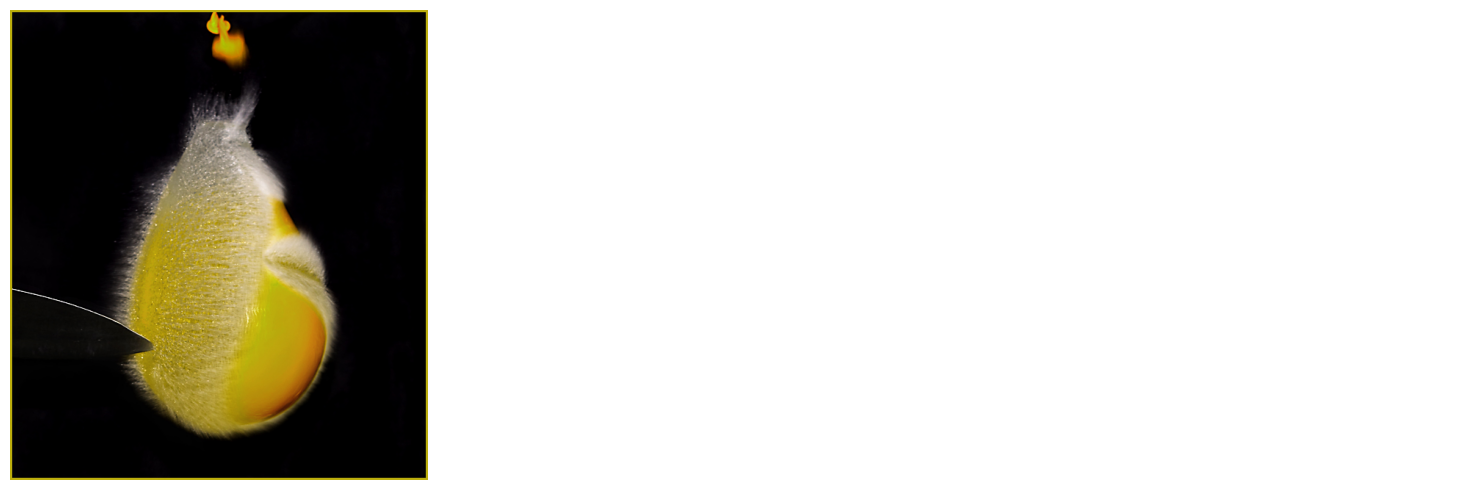

In [ ]:
plot_images(path_list)

## Steps

  - 이미지를 불러와 벡터로 바꿉니다
  - 벡터끼리의 거리를 계산합니다
  - 거리를 기준으로 정렬해서 가까운 이미지들을 선택합니다

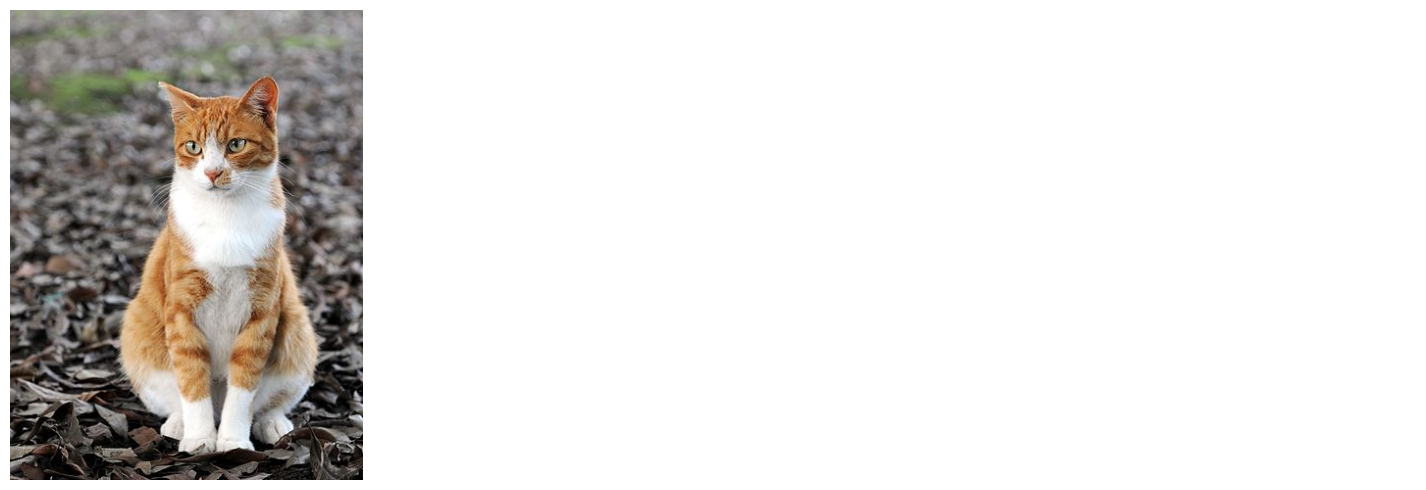

In [ ]:
import requests

# upload cat.jpg file!
local_path = "./cat.jpg"

plot_images([local_path])

In [ ]:
local_image = np.array([preprocess_image(local_path, IMAGE_SIZE)])
local_image_feature_vector = model.predict(local_image, batch_size=BATCH_SIZE)
local_image_feature_vector

1/1 [==============================] - 1s 832ms/step


array([[1.366438  , 0.5812689 , 0.        , ..., 0.        , 0.12670238,
        0.02148535]], dtype=float32)

In [ ]:
from scipy.spatial.distance import cosine

df["distance"] = df["feature_vector"].apply(lambda x: cosine(local_image_feature_vector[0], x))

df.sort_values("distance", ascending=True).head(5)

img_name                img_path       mos  \
483  ooqk1yldws  ./train/ooqk1yldws.jpg  5.236641   
408  z1pmy9qtvh  ./train/z1pmy9qtvh.jpg  5.084848   
466  vugg3faowk  ./train/vugg3faowk.jpg  4.611465   
684  7fifyl29ay  ./train/7fifyl29ay.jpg  5.780488   
698  3juzs5jflm  ./train/3juzs5jflm.jpg  5.527363   

                                              comments  \
483  a very sweet photo, and beautifully composed. ...   
408             beautiful portrait, incredible colors.   
466  you kept a fairly good balance in your focus.b...   
684  the stare still looks kind of complacent. and ...   
698           pretty warm tones and really nice light.   

                                        feature_vector  distance  
483  [0.24024641513824463, 0.25794702768325806, 0.0...  0.377218  
408  [0.0, 0.43237197399139404, 0.0, 0.0, 0.0517695...  0.537970  
466  [0.2793945074081421, 1.2415285110473633, 0.254...  0.546855  
684  [0.07504897564649582, 0.2415589988231659, 0.60...  0.547034  
698  [0.0, 0.42078882455825806, 0.9384318590164185,...  0.570496

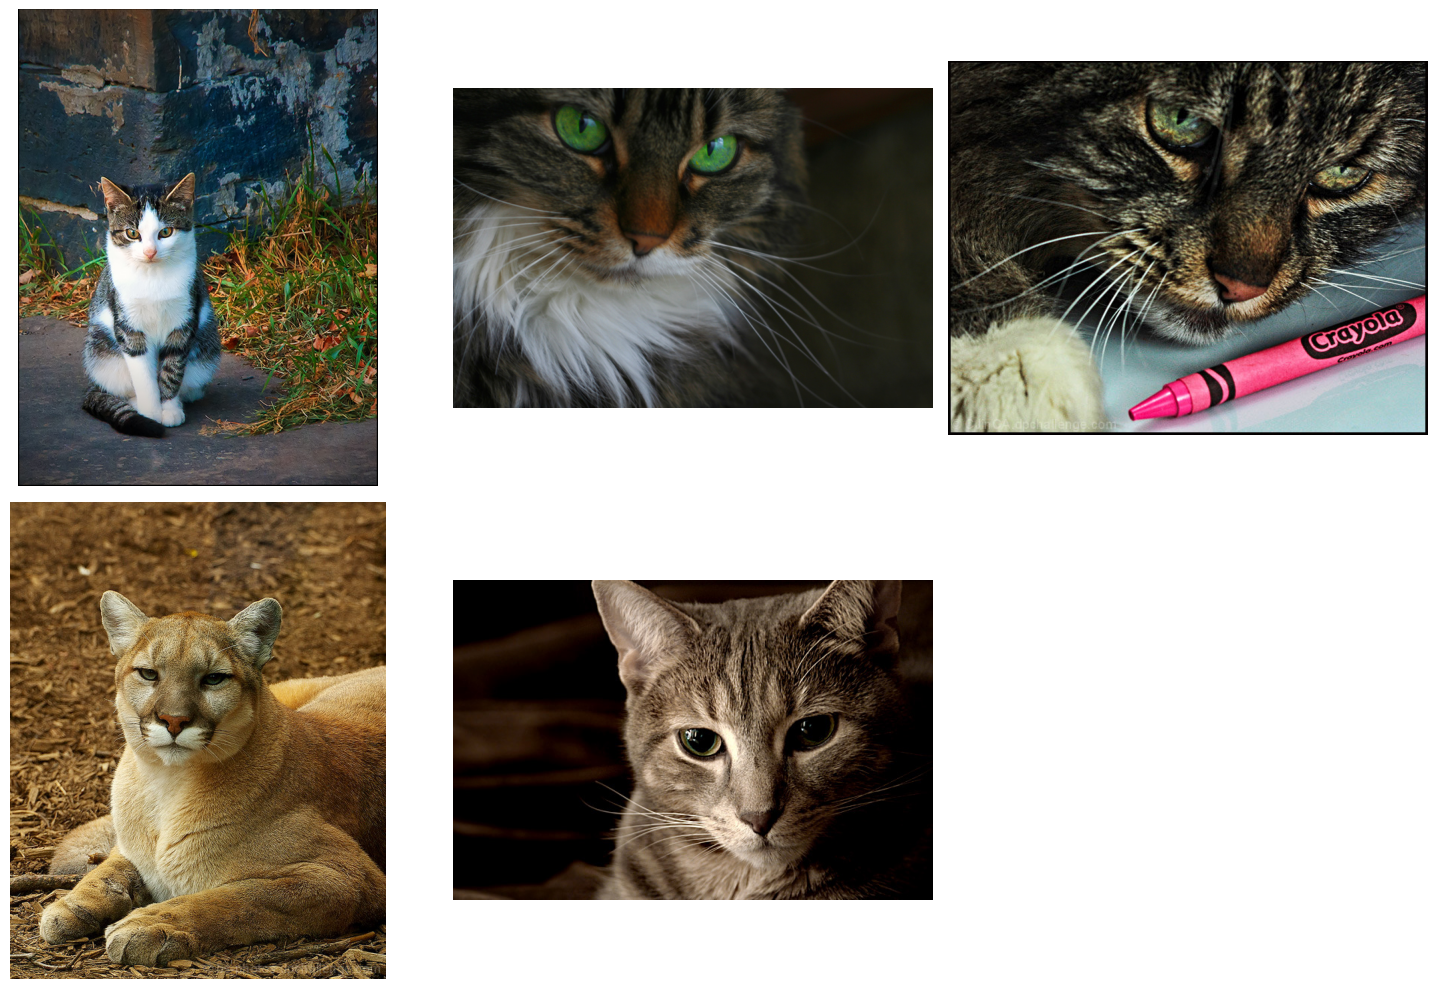

In [ ]:
img_paths = df.sort_values("distance", ascending=True).head(5)['img_path'].apply(add_prefix).tolist()
plot_images(img_paths)

# Text 는 그러면 어떻게 할까요??

- 방안 1. Multi-Modal Model 을 이용해 벡터를 구합니다 --> 바로 검색에 사용 가능함!!
- 방안 2. 이미지를 캡셔닝을 하고, 캡션 텍스트를 임베딩으로 바꿉니다. --> 한 단계가 더 필요하지만, 멀티모달 모델이 없어도 구현이 가능함.
  - 캡셔닝이 가능한 모델은 이미 멀티모달 모델이겠죠....??

- CLIP 이라는 멀티모달 모델을 받아서, 이미지와 텍스트의 벡터를 비교해 봅시다

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-f_zdw97z
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-f_zdw97z
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [ ]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 2.3.0+cu121


In [ ]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size
device = "cuda" if torch.cuda.is_available() else "cpu"

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 51.0MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
image = preprocess(Image.open("./cat.jpg")).unsqueeze(0).to(device)
image_features = model.encode_image(image)
image_features

tensor([[ 1.5601e-01,  1.8274e-01,  4.6069e-01, -7.6172e-01, -3.3667e-01,
         -6.6833e-02,  8.5938e-02,  3.7305e-01,  4.0588e-02,  1.6028e-01,
          4.0161e-01, -2.5146e-01, -1.1438e-01,  7.0496e-02,  2.2241e-01,
          4.0186e-01,  6.3086e-01,  4.5593e-02, -2.1399e-01, -1.7102e-01,
         -1.5759e-01,  1.4111e-01,  4.8926e-01, -3.1641e-01, -3.1885e-01,
          2.0776e-01,  1.6772e-01, -1.7725e-01, -3.9490e-02, -1.4795e-01,
          3.5156e-02,  5.1953e-01,  2.6196e-01, -2.3899e-03,  5.9229e-01,
          2.6953e-01,  1.5979e-01, -2.0874e-01,  1.1322e-01,  1.5732e+00,
         -4.8706e-01, -4.5825e-01,  1.1847e-01, -3.3887e-01,  3.3887e-01,
          1.6577e-01, -1.6907e-01,  2.0874e-02,  1.3647e-01, -5.4596e-02,
          2.3041e-02,  5.6592e-01, -2.6099e-01, -1.1975e-01, -5.3619e-02,
         -1.7639e-02,  4.3481e-01,  5.1758e-01, -2.5195e-01, -2.0129e-01,
          1.5557e+00,  1.3269e-01, -4.2944e-01,  3.3765e-01, -3.2642e-01,
         -5.8594e-01,  3.2471e-01,  2.

In [ ]:
#text = clip.tokenize("Orange tabby cat sitting on fallen leaves").to(device)
text = clip.tokenize("cyberpunk style night city").to(device)
text_features = model.encode_text(text)
text_features

tensor([[ 2.3697e-02, -1.0559e-01,  1.0765e-02, -4.2944e-01,  3.1372e-01,
         -2.7490e-01, -2.3083e-01,  2.4307e-02,  1.8323e-01,  2.4597e-02,
          1.4984e-02, -6.0156e-01,  4.0259e-01, -3.7964e-01,  3.9795e-01,
          2.8784e-01,  3.6670e-01,  6.8115e-02, -1.6248e-01, -1.0826e-02,
          1.3416e-01,  9.8450e-02,  2.0752e-01, -1.4880e-01, -1.8018e-01,
          2.9077e-01,  3.5205e-01, -6.2866e-02, -3.6682e-02,  2.3169e-01,
         -7.0251e-02, -1.4685e-01,  1.5857e-01,  3.0422e-04, -2.5635e-01,
         -7.0839e-03,  1.7932e-01,  7.3853e-02,  9.8755e-02, -1.6382e-01,
         -2.4805e-01,  2.6538e-01,  1.9031e-01,  1.1700e-01, -2.2681e-01,
          2.0044e-01,  2.1313e-01, -3.1885e-01,  2.6318e-01, -7.7942e-02,
          5.2588e-01, -1.2805e-01, -4.2554e-01,  1.3586e-01,  3.1201e-01,
         -5.9521e-01,  9.3384e-02,  1.0605e-02,  1.5381e-01, -1.3550e-01,
         -1.9543e-01,  4.4775e-04, -2.3474e-01,  2.1448e-01,  1.5576e-01,
         -1.5210e-01,  1.7676e-01, -5.

In [ ]:
cosine(image_features.cpu().detach().numpy()[0], text_features.cpu().detach().numpy()[0])

0.86962890625

# Zero-Shot Prediction

  - Vector 를 이용하면 Zero-Shot Prediction 이 가능하지 않을까?
  - Text 와 Image 의 벡터 거리를 구하고 비교하자!
  - Text Encoding 을 많이 해아하는 것이 단점...
  - 추가 학습 없이 Task 확장이 가능하다는 것이 장점

In [ ]:
from torchvision.datasets import CIFAR100

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

100%|██████████| 169001437/169001437 [00:12<00:00, 13162945.58it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache

Top predictions:

           tiger: 25.22%
             fox: 17.33%
             boy: 10.19%
    sweet_pepper: 7.69%
          orange: 4.59%


In [ ]:
cifar100.classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

# Make a Text to Image Searching!

  - Text 를 input 으로 넣으면 Image 가 찾아지도록 코드를 작성해 봅시다!

In [ ]:
text_to_search = "the yellow cat"

text = clip.tokenize(text_to_search).to(device)
text_features = model.encode_text(text)
#text_features

In [ ]:
with torch.no_grad():
  df["clip_encoded"] = df["img_path"].apply(lambda x:  model.encode_image( preprocess(Image.open(wd + x)).unsqueeze(0).to(device)).cpu().detach().numpy()[0] )
df

img_name                img_path       mos  \
0    8wej0zjjcg  ./train/8wej0zjjcg.jpg  5.393064   
1    7tp8y2wa0o  ./train/7tp8y2wa0o.jpg  5.668919   
2    njj6uo8dl7  ./train/njj6uo8dl7.jpg  4.550725   
3    gi7egofua1  ./train/gi7egofua1.jpg  5.661765   
4    jfobhikir5  ./train/jfobhikir5.jpg  2.400901   
..          ...                     ...       ...   
995  q9l9o2ym98  ./train/q9l9o2ym98.jpg  5.679144   
996  inuzo3y4sg  ./train/inuzo3y4sg.jpg  6.139535   
997  d9chiie2q3  ./train/d9chiie2q3.jpg  5.955479   
998  hr04byldlo  ./train/hr04byldlo.jpg  6.158537   
999  oqe121r97w  ./train/oqe121r97w.jpg  6.387435   

                                              comments  \
0    lovely photo, maybe a bit too dark because of ...   
1    i really like the way you have done these laye...   
2    cute and classy! i like this a lot especially ...   
3    nice and spooky, and you fit the bill for one ...   
4    im really trying to get this, but i dont. blue...   
..                                                 ...   
995  one of my s for the week. the colors are almos...   
996  lovely effect on the flowers with the backligh...   
997  very good! i love the grainyedgy look to it, b...   
998  very cute, and the colours are so warm, i can ...   
999  truly eerie. the use of light and shadows is d...   

                                        feature_vector  distance  \
0    [0.018101582303643227, 1.7087911367416382, 0.0...  0.729156   
1    [0.7232603430747986, 0.8315859436988831, 0.231...  0.622393   
2    [0.8634575605392456, 0.4482772648334503, 1.271...  0.754206   
3    [0.0, 0.0, 0.8987318277359009, 2.2514600753784...  0.680833   
4    [0.12598557770252228, 0.0, 0.0, 0.032762769609...  0.782531   
..                                                 ...       ...   
995  [0.03623422607779503, 0.06214340776205063, 0.1...  0.710195   
996  [0.059128254652023315, 0.6418329477310181, 0.0...  0.706281   
997  [0.10365883260965347, 0.0, 0.22335702180862427...  0.687614   
998  [0.014621962793171406, 0.22887499630451202, 1....  0.641174   
999  [0.0932057648897171, 1.202590823173523, 1.1679...  0.752551   

                                          clip_encoded  
0    [-0.2986, 0.3914, 0.1246, 0.1012, -0.2683, 0.3...  
1    [-0.02461, 0.11383, -0.2776, 0.5205, 0.02826, ...  
2    [0.2462, -0.1697, 0.2092, 0.591, -0.3423, -0.3...  
3    [-0.0956, 0.2803, 0.2808, 0.385, 0.09656, 0.32...  
4    [-0.08527, 0.1902, -0.2957, 0.11676, 0.2295, -...  
..                                                 ...  
995  [0.02962, 0.2341, 0.171, -0.0868, 0.341, 0.236...  
996  [-0.1761, 0.0451, -0.1534, 0.6606, -0.1501, 0....  
997  [0.2651, 0.2656, 0.04434, 0.3926, 0.1098, -0.5...  
998  [-0.05746, -0.0905, -0.2031, 0.2048, -0.000661...  
999  [-0.1385, 0.608, 0.1345, 0.3032, 0.2812, -0.06...  

[1000 rows x 7 columns]

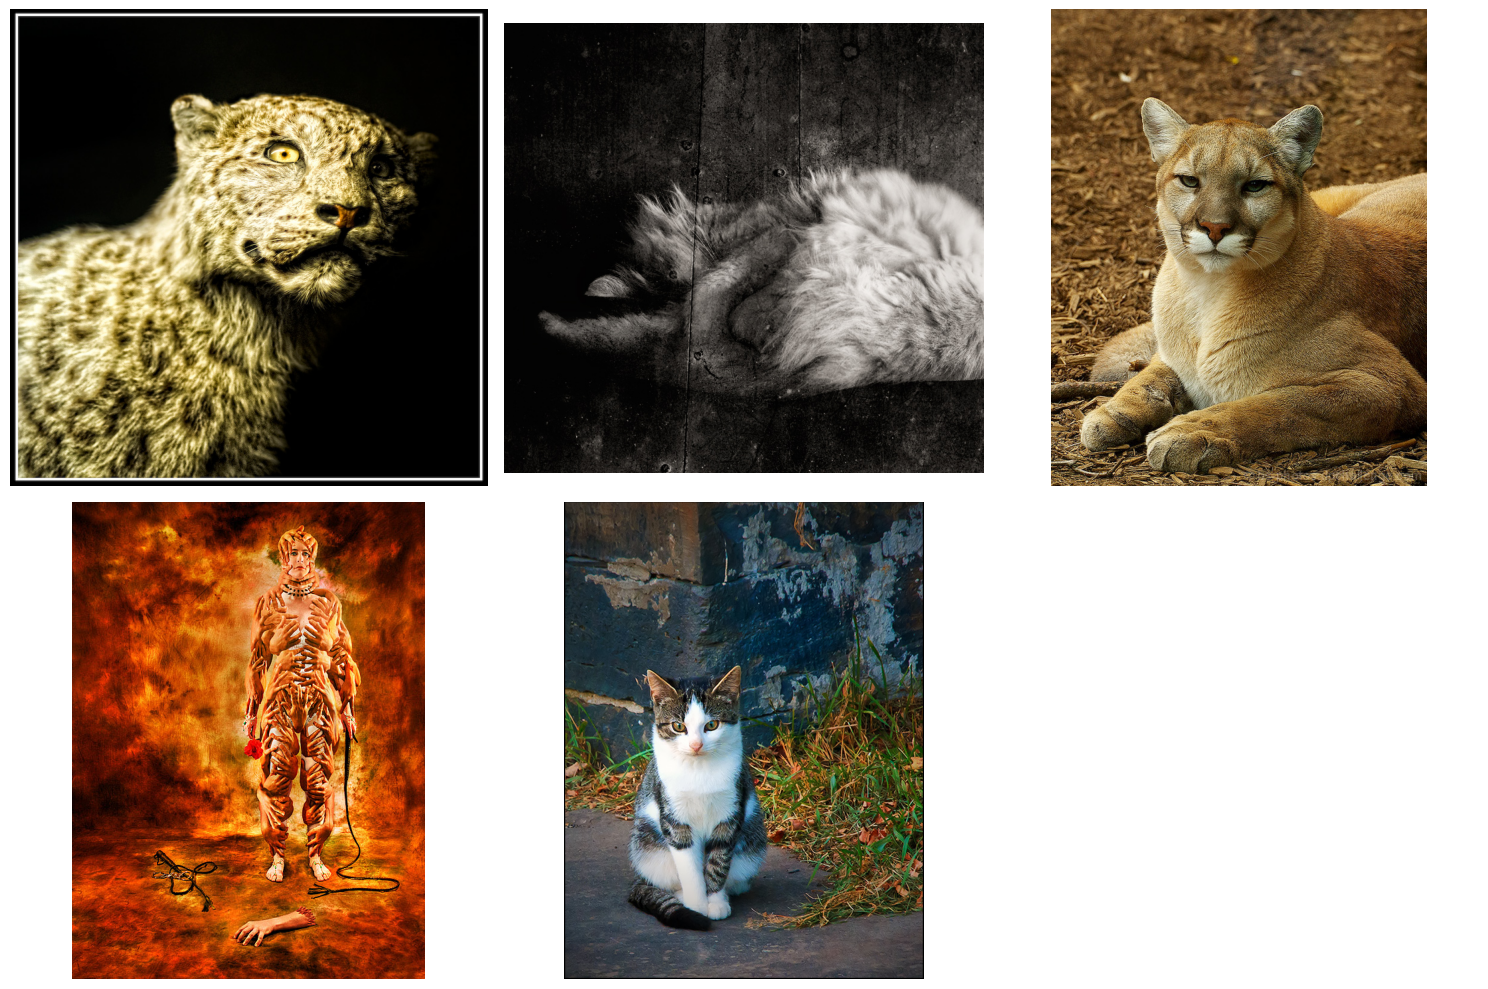

In [ ]:
df["clip_distance"] = df["clip_encoded"].apply(lambda x: cosine(text_features.cpu().detach().numpy()[0], x))
img_paths = df.sort_values("clip_distance", ascending=True).head(5)['img_path'].apply(add_prefix).tolist()
plot_images(img_paths)